# N-HiTS 

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from darts import TimeSeries

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [3]:
df = pd.read_csv('data/daily_min_temp.csv')

df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
series = TimeSeries.from_dataframe(df, time_col='Date', value_cols=['Temp'], fill_missing_dates=True, freq='d')

In [6]:
from darts.utils.missing_values import fill_missing_values

full_series = fill_missing_values(series)

<Axes: xlabel='Date'>

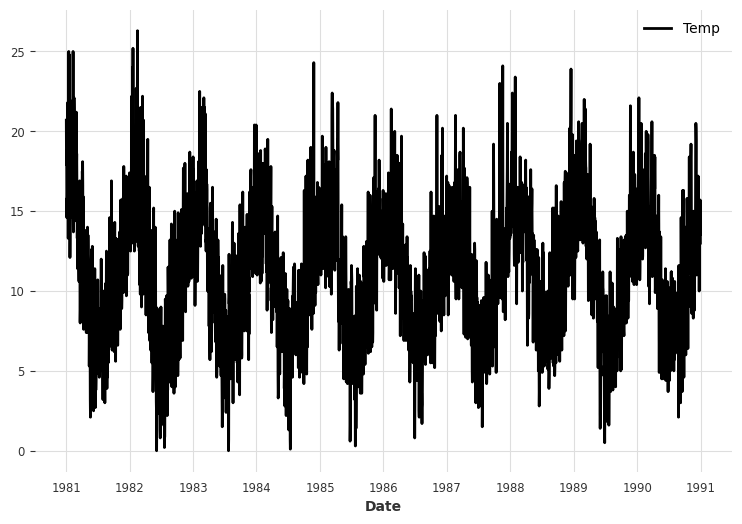

In [7]:
series.plot()

## Train/test split 

<Axes: xlabel='Date'>

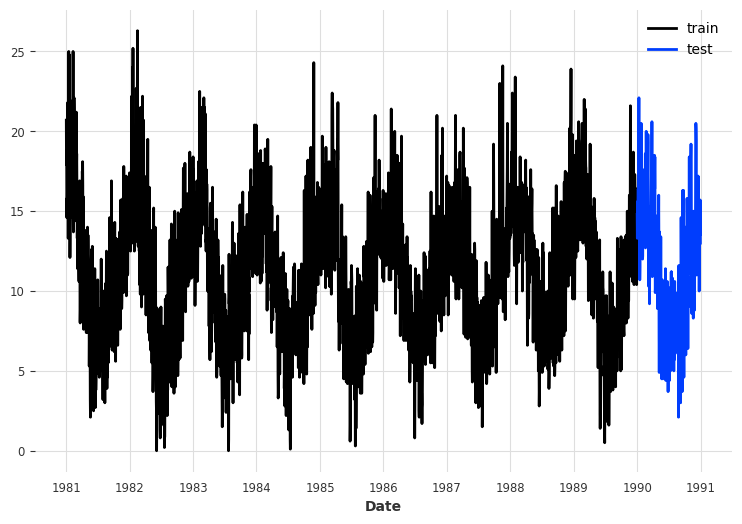

In [8]:
train, test = full_series[:-365], full_series[-365:]

train.plot(label='train')
test.plot(label='test')

## N-HiTS 

In [9]:
from darts.models import NHiTSModel
from darts.dataprocessing.transformers import Scaler

# Scale the data as a deep learning model and these perform better when scaled
train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

# Now instatiate the model
nhits = NHiTSModel(
    input_chunk_length=365,
    output_chunk_length=365,
    random_state=42
)

nhits.fit(scaled_train, epochs=15)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.4 M 
---------------------------------------------------
1.2 M     Trainable params
187 K     Non-trainable params
1.4 M     Total params
5.592     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


NHiTSModel(output_chunk_shift=0, num_stacks=3, num_blocks=1, num_layers=2, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=ReLU, MaxPool1d=True, input_chunk_length=365, output_chunk_length=365, random_state=42)

In [10]:
scaled_pred_nhits = nhits.predict(n=365)
pred_nhits = train_scaler.inverse_transform(scaled_pred_nhits)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

### Evaluation 

In [11]:
from darts.metrics import mae

mae_nhits = mae(test, pred_nhits)

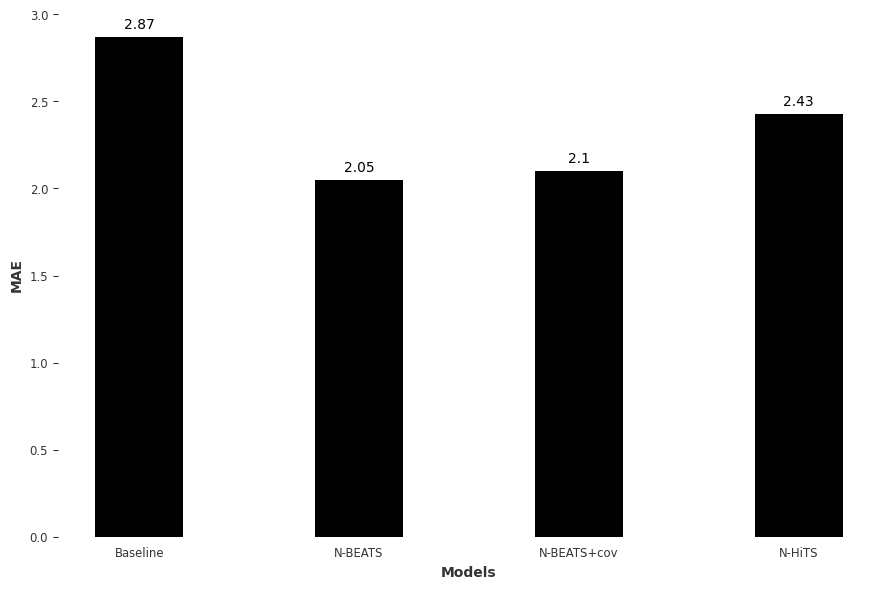

In [12]:
fig, ax = plt.subplots()

x = ['Baseline', 'N-BEATS', 'N-BEATS+cov', 'N-HiTS']
y = [2.87, 2.05, 2.10, mae_nhits]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.grid(False)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

## N-HiTS with covariates 

In [13]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

cov = dt_attr(series.time_index, 'month', dtype=np.float32)

In [14]:
cov_scaler = Scaler()

scaled_cov = cov_scaler.fit_transform(cov)

train_scaled_cov, test_sclaed_cov = scaled_cov[:-365], scaled_cov[-365:]

In [15]:
nhits_cov = NHiTSModel(
    input_chunk_length=365,
    output_chunk_length=365,
    random_state=42
)

nhits_cov.fit(scaled_train, past_covariates=scaled_cov, epochs=15)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.0 M 
---------------------------------------------------
1.6 M     Trainable params
374 K     Non-trainable params
2.0 M     Total params
8.022     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


NHiTSModel(output_chunk_shift=0, num_stacks=3, num_blocks=1, num_layers=2, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=ReLU, MaxPool1d=True, input_chunk_length=365, output_chunk_length=365, random_state=42)

In [16]:
scaled_pred_nhits_cov = nhits_cov.predict(past_covariates=scaled_cov, n=365)

pred_nhits_cov = train_scaler.inverse_transform(scaled_pred_nhits_cov)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

### Evaluation 

In [17]:
mae_nhits_cov = mae(test, pred_nhits_cov)

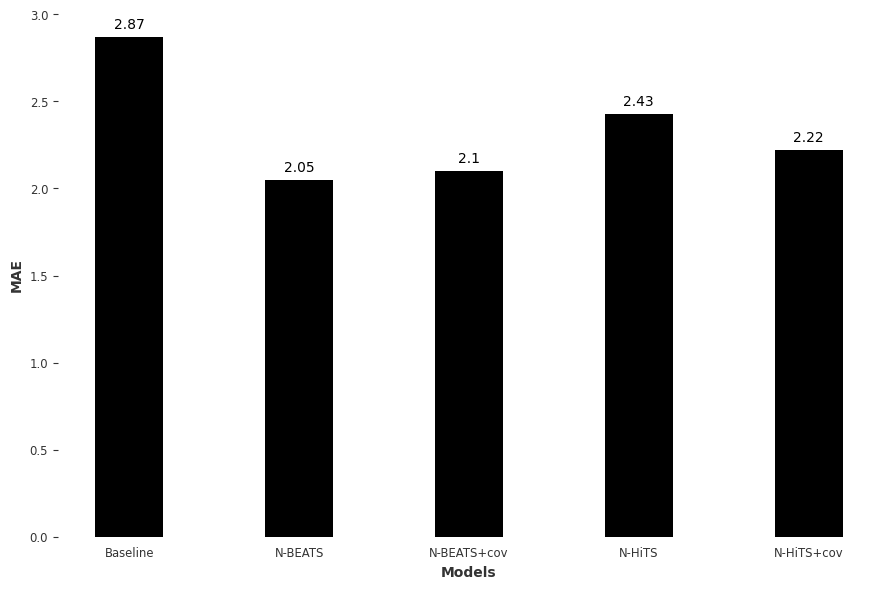

In [18]:
fig, ax = plt.subplots()

x = ['Baseline', 'N-BEATS', 'N-BEATS+cov', 'N-HiTS', 'N-HiTS+cov']
y = [2.87, 2.05, 2.10, mae_nhits, mae_nhits_cov]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.grid(False)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

### Plot predictions 

<Axes: xlabel='Date'>

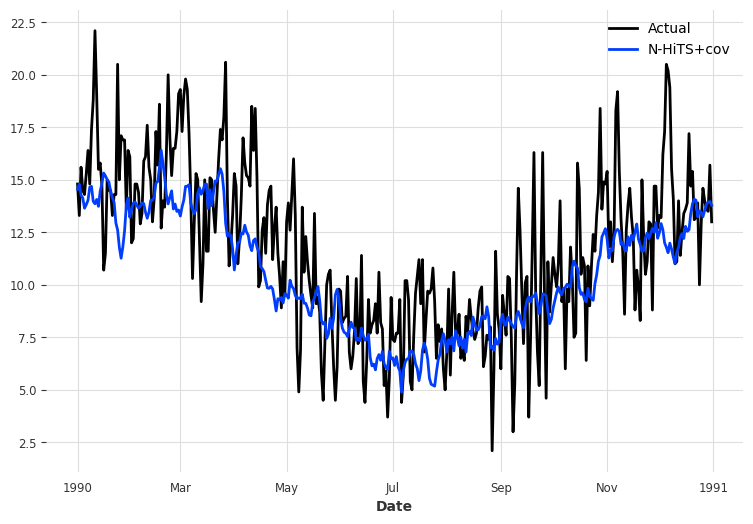

In [19]:
test.plot(label='Actual')
pred_nhits_cov.plot(label='N-HiTS+cov')